In [ ]:
!pip install stellargraph

In [ ]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import warnings
from copy import deepcopy
from tqdm import tqdm
import tensorflow_addons as tfa
from keras import backend as K 
warnings.filterwarnings("ignore")

In [57]:
def setup_SGC():
    generator = FullBatchNodeGenerator(G, method="sgc", k=2)
    classifier_model = GCN(
        layer_sizes=[train_targets.shape[1]],
        generator=generator,
        bias=True,
        dropout=0.5,
        activations=["softmax"],
        kernel_regularizer=regularizers.l2(5e-4),
    )
    return generator, classifier_model


def setup_GCN():
    generator = FullBatchNodeGenerator(G, method="gcn")
    classifier_model = GCN(
        layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
    )
    return generator, classifier_model


def setup_GraphSAGE():
    generator = GraphSAGENodeGenerator(G, 50, [10,5])
    classifier_model = GraphSAGE(
        layer_sizes=[32, 32], generator=generator, bias=False, dropout=0.5,
    )
    return generator, classifier_model

def setup_GAT():
    generator = FullBatchNodeGenerator(G, method="gat")
    classifier_model = GAT(
        layer_sizes=[8, train_targets.shape[1]],
        activations=["elu", "softmax"],
        attn_heads=8,
        generator=generator,
        in_dropout=0.5,
        attn_dropout=0.5,
        normalize=None,
    )
    return generator, classifier_model

In [7]:
import stellargraph as sg
import tensorflow as tf
from tensorflow import keras
import json
import os
import warnings
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN, GAT, DirectedGraphSAGE
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from stellargraph.mapper import DirectedGraphSAGENodeGenerator
from stellargraph import datasets
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def loadData(features, edge_list, labels):
    node_features = pd.DataFrame(features)
    source = edge_list[:,0]
    target = edge_list[:,1]
    edges = pd.DataFrame({"source": source, "target": target})
    G = sg.StellarDiGraph(node_features, edges, node_type_default="paper", edge_type_default="cites")
    node_subjects = pd.Series(labels)
    return G, node_subjects

def get_data(dataset):
    if dataset == "cora":
        G, node_subjects = datasets.Cora().load(directed=True)
    elif dataset == "pubmed":
        G, node_subjects = datasets.PubMedDiabetes().load()
    return G, node_subjects

def set_global_determinism(seed=12345):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_global_determinism()

In [59]:
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

In [64]:
def test(G, node_subjects, classifier_name, attack_num=0):
    train_subjects, val_subjects = model_selection.train_test_split(
        node_subjects, train_size=0.8, test_size=None, stratify=node_subjects,
        random_state=12345, shuffle=True
    )
    test_subjects = node_subjects[:-attack_num] if attack_num else node_subjects


    target_encoding = preprocessing.LabelBinarizer()

    train_targets = target_encoding.fit_transform(train_subjects)
    val_targets = target_encoding.transform(val_subjects)
    test_targets = target_encoding.transform(test_subjects)




    def setup_SGC():
        generator = FullBatchNodeGenerator(G, method="sgc", k=2)
        classifier_model = GCN(
            layer_sizes=[train_targets.shape[1]],
            generator=generator,
            bias=True,
            dropout=0.5,
            activations=["softmax"],
            kernel_regularizer=regularizers.l2(5e-4),
        )
        return generator, classifier_model


    def setup_GCN():
        generator = FullBatchNodeGenerator(G, method="gcn")
        classifier_model = GCN(
            layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
        )
        return generator, classifier_model


    def setup_GraphSAGE():
        generator = GraphSAGENodeGenerator(G, 50, [10,5])
        classifier_model = GraphSAGE(
            layer_sizes=[32, 32], generator=generator, bias=False, dropout=0.5,
        )
        return generator, classifier_model

    def setup_GAT():
        generator = FullBatchNodeGenerator(G, method="gat")
        classifier_model = GAT(
            layer_sizes=[8, train_targets.shape[1]],
            activations=["elu", "softmax"],
            attn_heads=8,
            generator=generator,
            in_dropout=0.5,
            attn_dropout=0.5,
            normalize=None,
        )
        return generator, classifier_model

    if classifier_name == "GCN":
        generator, classifier_model = setup_GCN()
        es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)
    elif classifier_name == "GraphSAGE":
        generator, classifier_model = setup_GraphSAGE()
    elif classifier_name == "GAT":
        generator, classifier_model = setup_GAT()
        if not os.path.isdir("logs"):
            os.makedirs("logs")
        es_callback = EarlyStopping(
            monitor="val_acc", patience=50
        )  # patience is the number of epochs to wait before early stopping in case of no further improvement
        mc_callback = ModelCheckpoint(
            "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
        )
    elif classifier_name == "SGC":
        generator, classifier_model = setup_SGC()
        if not os.path.isdir("logs"):
            os.makedirs("logs")
        es_callback = EarlyStopping(
            monitor="val_acc", patience=50
        )  # patience is the number of epochs to wait before early stopping in case of no further improvement
        mc_callback = ModelCheckpoint(
            "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
        )



    train_gen = generator.flow(train_subjects.index, train_targets)

    x_inp, x_out = classifier_model.in_out_tensors()

    predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

    val_gen = generator.flow(val_subjects.index, val_targets)

    test_gen = generator.flow(test_subjects.index, test_targets)

    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

    if classifier_name == "GAT":
        model = Model(inputs=x_inp, outputs=x_out)
        model.compile(
            optimizer=optimizers.Adam(lr=0.005),
            loss=losses.categorical_crossentropy,
            metrics=["acc"],
        )
        history = model.fit(
            train_gen,
            epochs=200,
            validation_data=val_gen,
            verbose=0,
            shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
            callbacks=[es_callback, mc_callback, tqdm_callback],
        )
    elif classifier_name == "GCN":
        model = Model(inputs=x_inp, outputs=predictions)
        model.compile(
            optimizer=optimizers.Adam(lr=0.01),
            loss=losses.categorical_crossentropy,
            metrics=["acc"],
        )
        history = model.fit(
            train_gen,
            epochs=200,
            validation_data=val_gen,
            verbose=0,
            shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
            callbacks=[es_callback, tqdm_callback],
        )
    elif classifier_name == "GraphSAGE":
        model = Model(inputs=x_inp, outputs=predictions)
        model.compile(
            optimizer=optimizers.Adam(lr=0.2),
            loss=losses.categorical_crossentropy,
            metrics=["acc"],
        )
        history = model.fit(
            train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
        )
    elif classifier_name == "SGC":
        model = Model(inputs=x_inp, outputs=x_out)
        model.compile(
            optimizer=optimizers.Adam(lr=0.2),
            loss=losses.categorical_crossentropy,
            metrics=["acc"],
        )
        history = model.fit(
            train_gen,
            epochs=200,
            validation_data=val_gen,
            verbose=0,
            shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
            callbacks=[es_callback, mc_callback, tqdm_callback],
        )


#     sg.utils.plot_history(history)

    test_metrics = model.evaluate(test_gen)
#     print("\nTest Set Metrics:")
#     for name, val in zip(model.metrics_names, test_metrics):
#         print("\t{}: {:0.4f}".format(name, val))
    return model, test_metrics[1], x_inp, x_out, generator, target_encoding

Using GCN (local pooling) filters...


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

1/1 [==============================] - 0s 66ms/step - loss: 0.2330 - acc: 0.9250
Using GCN (local pooling) filters...


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

1/1 [==============================] - 0s 54ms/step - loss: 0.2550 - acc: 0.9044


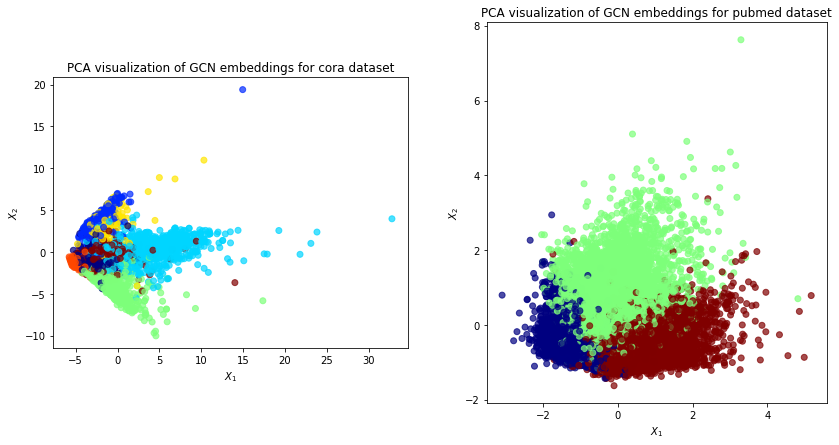

In [65]:
dataset_name = ['cora', 'pubmed']
classifier_name = "GCN"
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for i in range(2):
    G, node_subjects = get_data(dataset_name[i])
    model, _, x_inp, x_out, generator, _ = test(G, node_subjects, classifier_name)

    all_nodes = node_subjects.index
    all_gen = generator.flow(all_nodes)
    all_predictions = model.predict(all_gen)

    embedding_model = Model(inputs=x_inp, outputs=x_out)
    emb = embedding_model.predict(all_gen)

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    transform = PCA  # or PCA
    X = emb.squeeze(0)
    trans = transform(n_components=2)
    X_reduced = trans.fit_transform(X)
    X_reduced.shape

    axes[i].scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        c=node_subjects.astype("category").cat.codes,
        cmap="jet",
        alpha=0.7,
    )
    axes[i].set(
        aspect="equal",
        xlabel="$X_1$",
        ylabel="$X_2$",
        title=f"{transform.__name__} visualization of {classifier_name} embeddings for {dataset_name[i]} dataset",
    )
plt.savefig(f'{classifier_name}_plot.png')
plt.show()

Training:   0%|           0/200 ETA: ?s,  ?epochs/s

1/1 [==============================] - 0s 53ms/step - loss: 0.2224 - acc: 0.9302


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

1/1 [==============================] - 0s 128ms/step - loss: 0.3428 - acc: 0.8729


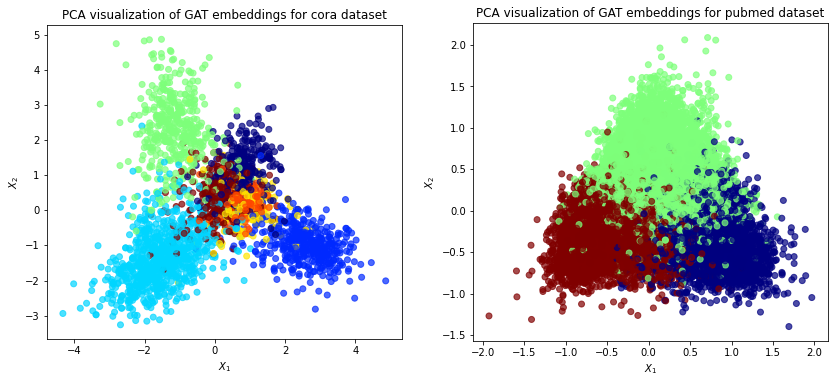

In [66]:
dataset_name = ['cora', 'pubmed']
classifier_name = "GAT"
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for i in range(2):
    G, node_subjects = get_data(dataset_name[i])
    model, _, x_inp, x_out, generator, target_encoding = test(G, node_subjects, classifier_name)

    all_nodes = node_subjects.index
    all_gen = generator.flow(all_nodes)
    all_predictions = model.predict(all_gen)

    emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))
    embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)
    emb = embedding_model.predict(all_gen)
    
    X = emb.squeeze()
    y = np.argmax(target_encoding.transform(node_subjects), axis=1)

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    if X.shape[1] > 2:
        transform = PCA  # PCA

        trans = transform(n_components=2)
        emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
        emb_transformed["label"] = y
    else:
        emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
        emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
        emb_transformed["label"] = y

    axes[i].scatter(
        emb_transformed[0],
        emb_transformed[1],
        c=emb_transformed["label"].astype("category"),
        cmap="jet",
        alpha=0.7,
    )
    axes[i].set(
        aspect="equal",
        xlabel="$X_1$",
        ylabel="$X_2$",
        title=f"{transform.__name__} visualization of {classifier_name} embeddings for {dataset_name[i]} dataset",
    )
plt.savefig(f'{classifier_name}_plot.png')
plt.show()

Epoch 1/20
44/44 - 4s - loss: 0.9872 - acc: 0.6574 - val_loss: 0.3933 - val_acc: 0.8744
Epoch 2/20
44/44 - 3s - loss: 0.4367 - acc: 0.8693 - val_loss: 0.2962 - val_acc: 0.9088
Epoch 3/20
44/44 - 2s - loss: 0.3452 - acc: 0.8924 - val_loss: 0.2610 - val_acc: 0.9199
Epoch 4/20
44/44 - 2s - loss: 0.3061 - acc: 0.8984 - val_loss: 0.2374 - val_acc: 0.9247
Epoch 5/20
44/44 - 3s - loss: 0.2631 - acc: 0.9123 - val_loss: 0.2323 - val_acc: 0.9250
Epoch 6/20
44/44 - 2s - loss: 0.2510 - acc: 0.9146 - val_loss: 0.2393 - val_acc: 0.9247
Epoch 7/20
44/44 - 2s - loss: 0.2456 - acc: 0.9211 - val_loss: 0.2260 - val_acc: 0.9309
Epoch 8/20
44/44 - 3s - loss: 0.2468 - acc: 0.9187 - val_loss: 0.2084 - val_acc: 0.9383
Epoch 9/20
44/44 - 3s - loss: 0.2414 - acc: 0.9252 - val_loss: 0.2041 - val_acc: 0.9372
Epoch 10/20
44/44 - 2s - loss: 0.2042 - acc: 0.9312 - val_loss: 0.2381 - val_acc: 0.9261
Epoch 11/20
44/44 - 2s - loss: 0.2137 - acc: 0.9275 - val_loss: 0.2159 - val_acc: 0.9346
Epoch 12/20
44/44 - 2s - loss:

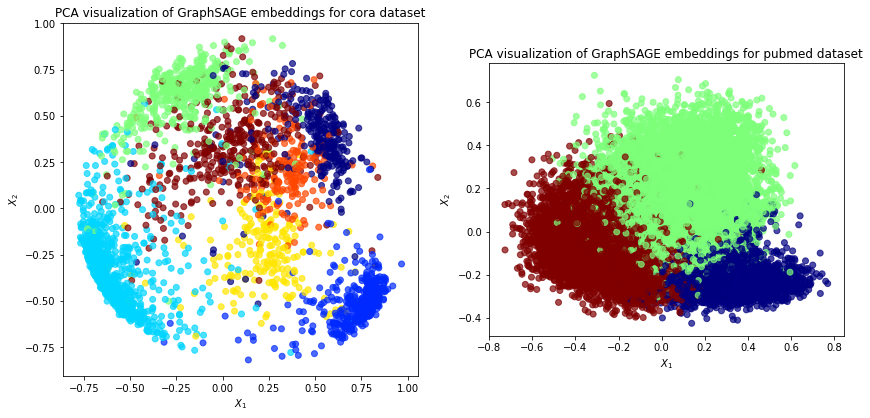

In [67]:
dataset_name = ['cora', 'pubmed']
classifier_name = "GraphSAGE"
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for i in range(2):
    G, node_subjects = get_data(dataset_name[i])
    model, _, x_inp, x_out, generator, target_encoding = test(G, node_subjects, classifier_name)

    all_nodes = node_subjects.index
    all_gen = generator.flow(all_nodes)
    all_predictions = model.predict(all_gen)

    embedding_model = Model(inputs=x_inp, outputs=x_out)
    emb = embedding_model.predict(all_gen)

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    X = emb
    y = np.argmax(target_encoding.transform(node_subjects), axis=1)
    if X.shape[1] > 2:
        transform = PCA  # PCA

        trans = transform(n_components=2)
        emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_subjects.index)
        emb_transformed["label"] = y
    else:
        emb_transformed = pd.DataFrame(X, index=node_subjects.index)
        emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
        emb_transformed["label"] = y

    axes[i].scatter(
        emb_transformed[0],
        emb_transformed[1],
        c=emb_transformed["label"].astype("category"),
        cmap="jet",
        alpha=0.7,
    )
    axes[i].set(
        aspect="equal",
        xlabel="$X_1$",
        ylabel="$X_2$",
        title=f"{transform.__name__} visualization of {classifier_name} embeddings for {dataset_name[i]} dataset",
    )
plt.savefig(f'{classifier_name}_plot.png')
plt.show()

In [68]:
from tensorflow.keras import layers, optimizers, losses, metrics, Model, regularizers

Calculating 2-th power of normalized A...


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

1/1 [==============================] - 0s 46ms/step - loss: 0.5391 - acc: 0.9140
Calculating 2-th power of normalized A...


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

1/1 [==============================] - 0s 86ms/step - loss: 0.8987 - acc: 0.7700


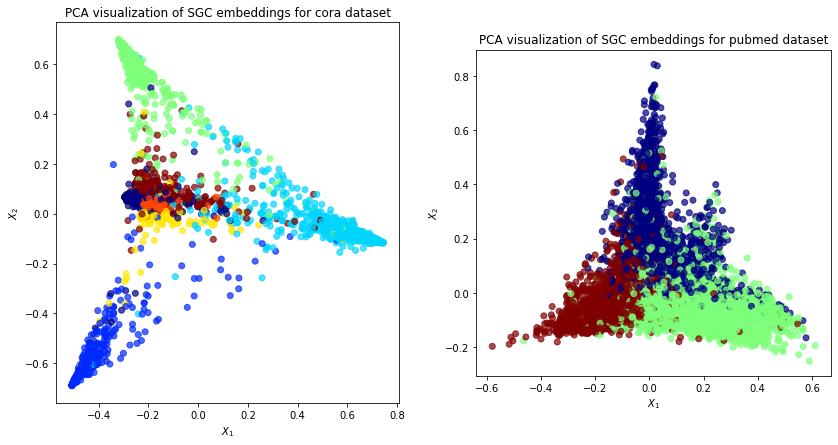

In [69]:
dataset_name = ['cora', 'pubmed']
classifier_name = "SGC"
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for i in range(2):
    G, node_subjects = get_data(dataset_name[i])
    model, _, x_inp, x_out, generator, target_encoding = test(G, node_subjects, classifier_name)

    all_nodes = node_subjects.index
    all_gen = generator.flow(all_nodes)
    all_predictions = model.predict(all_gen)

    all_predictions = all_predictions.squeeze()

    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    X = all_predictions
    y = np.argmax(target_encoding.transform(node_subjects), axis=1)
    if X.shape[1] > 2:
        transform = PCA  # PCA

        trans = transform(n_components=2)
        emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_subjects.index)
        emb_transformed["label"] = y
    else:
        emb_transformed = pd.DataFrame(X, index=node_subjects.index)
        emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
        emb_transformed["label"] = y

    axes[i].scatter(
        emb_transformed[0],
        emb_transformed[1],
        c=emb_transformed["label"].astype("category"),
        cmap="jet",
        alpha=0.7,
    )
    axes[i].set(
        aspect="equal",
        xlabel="$X_1$",
        ylabel="$X_2$",
        title=f"{transform.__name__} visualization of {classifier_name} embeddings for {dataset_name[i]} dataset",
    )
plt.savefig(f'{classifier_name}_plot.png')
plt.show()

In [22]:
G, node_subjects = get_data("cora")
classifier_name = "GCN"
loss_function = 3
attack_num = 100

ata = AttackingAlgo(G.nodes(), G.node_features(), G.edges(), node_subjects)
_, model, outputs = ata.test()

In [25]:
print(model)

NeighborModel(
  (ff1): Sequential(
    (0): BatchNorm1d(2866, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=2866, out_features=32, bias=True)
    (3): GELU()
  )
  (ff2): Sequential(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU()
  )
  (ff3): Sequential(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU()
  )
  (top): Linear(in_features=32, out_features=7, bias=True)
)
